# OVERLAPPING STOCHASTIC BLOCK MODELS WITH APPLICATION TO THE FRENCH POLITICAL BLOGOSPHERE

## Librairies

In [1]:
import numpy as np
import scipy
from scipy.special import expit
from scipy.optimize import minimize
import sparsebm
import torch
import numpy as np
import parametrization_cookbook.torch as pc
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm
from scipy.special import log1p
from copy import deepcopy

## Classical SBM

### Generate SBM

In [2]:
def SBM(n_nodes = 10, n_classes = 3, prob_classes = None, alpha = None, self_loop = True):
    """Generate SBM"""
    if prob_classes is None:
        prob_classes = np.ones(shape=n_classes) / n_classes
    if alpha is None:
        alpha = np.ones(shape=(n_classes, n_classes)) / 10
        np.fill_diagonal(alpha, 0.9)
    # Create Z, class vector
    Z = np.random.choice([i for i in range(n_classes)], size=n_nodes, p=prob_classes)
    # Generate bernouilli law
    alpha_expanded = alpha[Z][:, Z]
    X = np.random.binomial(n=1, p=alpha_expanded)
    if not self_loop:
        np.fill_diagonal(X, 0)
    return Z, X

### Inference on SBM

In [3]:
def get_entropy_and_expectation_log_likelihood(X_tensor, param_gamma, param_pi, param_alpha, gamma_prime, pi_prime, alpha_prime):
    """Return the entropy and expectation log-likelihood from the unconstrained parameters"""
    gamma = param_gamma.reals1d_to_params(gamma_prime)
    pi = param_pi.reals1d_to_params(pi_prime)
    alpha = param_alpha.reals1d_to_params(alpha_prime)

    entropy = - torch.einsum("ik,ik->", gamma, torch.log(gamma))
    expectation_log_likelihood = (torch.einsum("ik,k->", gamma, torch.log(pi)) 
                                  + torch.einsum("ik,jl,ij,kl->", gamma, gamma, X_tensor, torch.log(alpha))
                                  + torch.einsum("ik,jl,ij,kl->", gamma, gamma, 1 - X_tensor, torch.log(1-alpha))) 
    return entropy, expectation_log_likelihood

def ICL(expectation, K, n):
    """Compute ICL"""
    return expectation - 0.5 * (K - 1) * np.log(n) - 0.5 * K**2 * np.log(n**2)

In [4]:
def get_best_model(adjacency_matrix, K_begin = 2, K_end = 10, K_step = 1, n_iter = 3, max_optim_iter = 5000, lr = 0.1):
    ICLs = []
    models_params = []
    # Loop over K
    for K in range(K_begin, K_end + 1, K_step):
        ICLs_K = []
        models_params_K = []
        # Loop over n_iter
        for i in range(n_iter):
            # Initialize parameters
            param_gamma = pc.VectorSimplex(dim = K-1, shape=(adjacency_matrix.shape[0], ))
            param_pi = pc.VectorSimplex(dim=K-1)
            param_alpha = pc.RealBounded01(shape=(K,K))

            gp = torch.randn(param_gamma.size).clone().detach().requires_grad_(True)
            pp = torch.randn(param_pi.size).clone().detach().requires_grad_(True)
            ap = torch.randn(param_alpha.size).clone().detach().requires_grad_(True)

            optim = torch.optim.Adam([gp, pp, ap], lr=lr)
            
            # Optimize
            for i in range(max_optim_iter):
                optim.zero_grad()
                entropy, expectation_log_lik = get_entropy_and_expectation_log_likelihood(adjacency_matrix, param_gamma, param_pi, param_alpha, gp, pp, ap)
                elbo = entropy + expectation_log_lik
                (-elbo).backward()
                optim.step()
            ICLs_K.append(ICL(expectation_log_lik.item(), K, adjacency_matrix.shape[0]))
            table_params = (param_gamma.reals1d_to_params(gp), param_pi.reals1d_to_params(pp), param_alpha.reals1d_to_params(ap))
            models_params_K.append(table_params)
        ICLs.append(np.max(ICLs_K))
        models_params.append(models_params_K[np.argmax(ICLs_K)])
        print(f"K = {K}, ICL = {ICLs[-1]}")
        # Return model params of best model
    return models_params[np.argmax(ICLs)]

### Example

In [30]:
N = 500
K = 4

Z, X = SBM(N, K)
X = torch.tensor(X, dtype=torch.float32)

In [31]:
model_params = get_best_model(X)
model_params

K = 2, ICL = -127795.9579239429
K = 3, ICL = -103088.70858098422
K = 4, ICL = -102828.66189172238
K = 5, ICL = -102894.0522311574
K = 6, ICL = -103045.86397428926
K = 7, ICL = -82630.51899611796
K = 8, ICL = -82740.84542164349
K = 9, ICL = -124689.42918836589
K = 10, ICL = -82955.55154628512


(tensor([[2.9774e-05, 9.7254e-01, 2.1716e-06,  ..., 1.2583e-05, 2.3129e-05,
          2.7391e-02],
         [9.2796e-01, 7.4676e-06, 7.1924e-02,  ..., 1.5005e-06, 4.0534e-06,
          5.5639e-07],
         [1.6709e-05, 9.8025e-01, 3.1664e-06,  ..., 8.1072e-06, 1.2039e-05,
          1.9710e-02],
         ...,
         [1.5140e-05, 4.0650e-06, 1.0797e-05,  ..., 7.0257e-04, 3.3585e-06,
          1.0703e-06],
         [1.5326e-05, 4.4771e-06, 1.5039e-06,  ..., 1.4515e-05, 9.9995e-01,
          1.0504e-05],
         [1.7446e-05, 1.2381e-05, 1.5556e-05,  ..., 4.0713e-04, 1.1382e-05,
          1.5603e-06]], grad_fn=<SoftmaxBackward0>),
 tensor([2.2371e-01, 2.3305e-01, 1.2289e-02, 2.8588e-01, 2.0996e-04, 2.3991e-01,
         4.9577e-03], grad_fn=<SoftmaxBackward0>),
 tensor([[0.8983, 0.0980, 0.8976, 0.1020, 0.2265, 0.1006, 0.0965],
         [0.0994, 0.8969, 0.0985, 0.0987, 0.1822, 0.0980, 0.8955],
         [0.8965, 0.0978, 0.8956, 0.1030, 0.2762, 0.1000, 0.0970],
         [0.0989, 0.0983, 0.1

## Overlapping stochastic block model

### Generate OSBM

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit

class OSBM:
    def __init__(self, n_nodes=10, Q=3, alpha=None, W=None, U=None, V=None, W_star=None):
        """Initialize the OSBM model."""
        if alpha is None:
            alpha = np.ones(Q) / Q  # Uniform probabilities for clusters
        if W is None:
            W = np.random.rand(Q, Q)  # Random interaction matrix
        if U is None:
            U = np.random.rand(Q)  # Random sender effects
        if V is None:
            V = np.random.rand(Q)  # Random receiver effects
        if W_star is None:
            W_star = np.random.rand()  # Random bias term

        self.n_nodes = n_nodes
        self.Q = Q
        self.alpha = np.array(alpha)
        self.W = np.array(W)
        self.U = np.array(U)
        self.V = np.array(V)
        self.W_star = W_star

    def sample_graph(self):
        """Generate a random graph based on the OSBM model."""
        # Sample Z[i] for each node i with binomial distribution
        Z = np.random.binomial(1, self.alpha, size=(self.n_nodes, self.Q))
        
        # Initialize the adjacency matrix X (n_nodes x n_nodes)
        X = np.zeros((self.n_nodes, self.n_nodes))

        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if i != j:  # Avoid self-loops
                    # Compute interaction term a_{Z_i, Z_j}
                    interaction_term = (
                        np.dot(Z[i], np.dot(self.W, Z[j]))  # Z_i @ W @ Z_j
                        + np.dot(Z[i], self.U)             # Z_i @ U
                        + np.dot(self.V, Z[j])             # V @ Z_j
                        + self.W_star                     # Bias term W_star
                    )

                    # Compute edge probability using the sigmoid (logistic function)
                    p_edge = expit(interaction_term)
                    
                    # Generate edge with probability p_edge
                    X[i, j] = np.random.binomial(1, p_edge)

        self.Z = Z
        self.X = X
    
    def plot(self):
        """Plot graph with networkx with different colors for classes."""
        G = nx.from_numpy_array(self.X)
        pos = nx.spring_layout(G)

        # Generate a color map for the graph
        color_map = []
        for node in G.nodes:
            # Outliers are grey
            if sum(self.Z[node]) == 0:
                color = 'grey'
            # Single membership nodes are colored by their class
            elif sum(self.Z[node]) == 1:
                color = self.Z[node].argmax()  # Get class index
            # Multiple membership nodes are black
            else:
                color = 'black'  # Use 'black' for nodes with multiple memberships

            color_map.append(color)

        # Convert numeric class indices to matplotlib-compatible colors
        unique_classes = sorted(set(color_map) - {'black'} - {'grey'})  # Exclude black from unique classes
        class_to_color = {c: plt.cm.tab10(i % 10) for i, c in enumerate(unique_classes)} 
        class_to_color['black'] = 'black'  # Add black for overlaps
        class_to_color['grey'] = 'grey'

        node_colors = [class_to_color[c] for c in color_map]

        # Draw the graph
        nx.draw(G, pos, node_color=node_colors, with_labels=True, font_color='white', edge_color='gray')
        plt.show()


    def variational_EM(self, Q, max_iter=100, tol=1e-10):
        """
        Perform Variational EM to estimate parameters of the OSBM model.

        Parameters:
            X (np.ndarray): Adjacency matrix of the graph.
            Q (int): Number of clusters.
            max_iter (int): Maximum number of iterations.
            tol (float): Convergence tolerance for variational parameters.

        Returns:
            dict: Estimated parameters {"alpha": alpha, "W": W}.
        """
        X = self.X
        N = X.shape[0]

        def initialization(X, Q, sigma=1.0):
            clustering = AgglomerativeClustering(n_clusters=Q, affinity='precomputed', linkage='average')
            clustering.fit(1 - X)

            tau = np.zeros((N, Q))
            for i, label in enumerate(clustering.labels_):
                tau[i, label] = 1
            tau += np.random.rand(N, Q) * 0.01
            tau /= tau.sum(axis=1, keepdims=True)

            W = np.random.normal(loc=0, scale=sigma, size=(Q, Q))

            return tau, W

        def compute_xi(tau, W):
            quadratic_term = np.einsum("iq,qr,jq->ij", tau, W, tau)
            return quadratic_term

        def g(xi):
            return log1p(np.exp(xi))

        def lambd(xi):
            sigmoid = expit(xi)
            return sigmoid * (1 - sigmoid)

        def compute_lower_bound(X, tau, W, alpha, xi):
            first_term = 0
            for i in range(N):
                for j in range(N):
                    if i != j:
                        log_g = g(xi[i, j])
                        lambda_term = lambd(xi[i, j]) * np.trace(W.T @ W)
                        first_term += (
                            (X[i, j] - 0.5) * tau[i].T @ W @ tau[j]
                            + log_g
                            - xi[i, j] / 2
                            - lambda_term
                        )

            tau_prior = np.sum(tau * np.log(np.clip(alpha, 1e-10, 1)) + (1 - tau) * np.log(np.clip(1 - alpha, 1e-10, 1)))
            tau_entropy = np.sum(tau * np.log(np.clip(tau, 1e-10, 1)) + (1 - tau) * np.log(np.clip(1 - tau, 1e-10, 1)))

            return first_term + tau_prior - tau_entropy

        def optimize_alpha(tau):
            return tau.mean(axis=0)

        def optimize_W(X, tau, W, alpha, xi):
            def loss(W_flat):
                W = W_flat.reshape(Q, Q)
                return -compute_lower_bound(X, tau, W, alpha, xi)

            W_init = W.flatten()
            result = minimize(loss, W_init, method="L-BFGS-B")
            return result.x.reshape(Q, Q)

        def optimize_tau_for_node(i, X, tau, W, alpha, xi):
            def loss(tau_i_flat):
                tau[i] = tau_i_flat.reshape(1, Q)
                return -compute_lower_bound(X, tau, W, alpha, xi)

            tau_init = np.random.rand(1, Q)
            bounds = [(0, 1)] * Q
            result = minimize(loss, tau_init.flatten(), method="L-BFGS-B", bounds=bounds)
            return result.x.reshape(1, Q)

        # Step 1 : Initialization
        print("Initializing...")
        tau, W = initialization(X, Q)
        alpha = np.ones(Q) / Q

        for iteration in range(max_iter):
            print(f"Iteration {iteration + 1}...")
            new_tau = deepcopy(tau)
            # Step 2 : xi transformation
            xi = compute_xi(new_tau, W)

            # Step 3 : M-step
            alpha = optimize_alpha(new_tau)
            W = optimize_W(X, tau, W, alpha, xi)

            # Step 4 : E-step
            for i in range(N):
                new_tau[i] = optimize_tau_for_node(i, X, tau, W, alpha, xi)
            print(new_tau, tau)
            # Check for convergence
            if np.linalg.norm(new_tau - tau) < tol:
                print(f"Converged in {iteration + 1} iterations.")
                break

        return {"alpha": alpha, "W": W}

### Simulation with 10 nodes and equal class probabilities

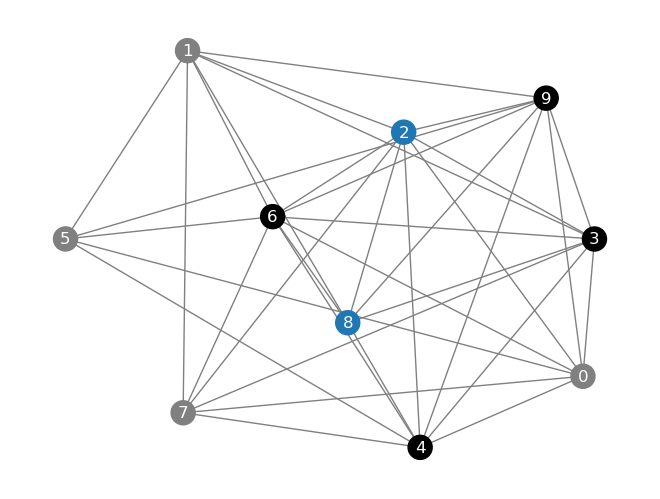

[[0 0 0]
 [0 0 0]
 [1 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [1 0 0]
 [1 1 0]]


In [4]:
N = 10
Q = 3  # Number of clusters
alpha = [0.3, 0.3, 0.3]  # Probabilities for each class
W = np.array([[1.0, 0.5, 0.1], [0.5, 1.5, 0], [0, 0, 1]])  # Interaction matrix
U = [0.2, 0.1, 0.7]  # Sender effects
V = [0.3, 0.6, 0.2]  # Receiver effects
W_star = -0.5  # Bias term

osbm = OSBM(N, Q, alpha, W, U, V, W_star)
osbm.sample_graph()
osbm.plot()
print(osbm.Z)

### Simulation with 10 nodes and balanced class probabilities

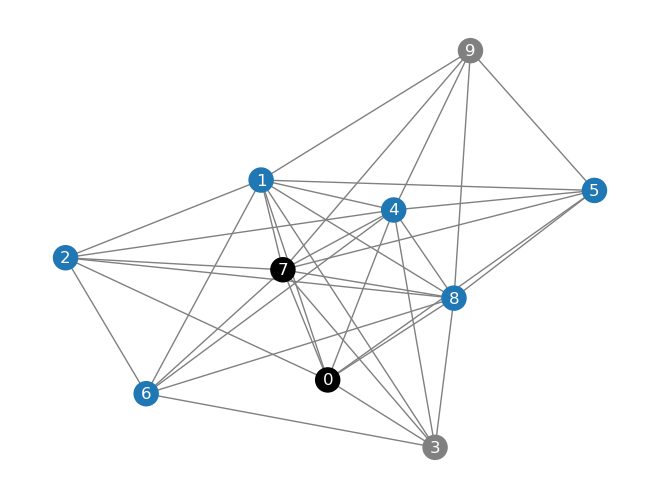

[[1 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 1 0]
 [1 0 0]
 [0 0 0]]


In [25]:
N = 10
Q = 3  # Number of clusters
alpha = [0.7, 0.2, 0.2]  # Probabilities for each class
W = np.array([[1.0, 0.5, 0.1], [0.5, 1.5, 0], [0, 0, 1]])  # Interaction matrix
U = [0.2, 0.1, 0.7]  # Sender effects
V = [0.3, 0.6, 0.2]  # Receiver effects
W_star = -0.5  # Bias term

osbm = OSBM(N, Q, alpha, W, U, V, W_star)
osbm.sample_graph()
osbm.plot()
print(osbm.Z)

### Test with paper's example

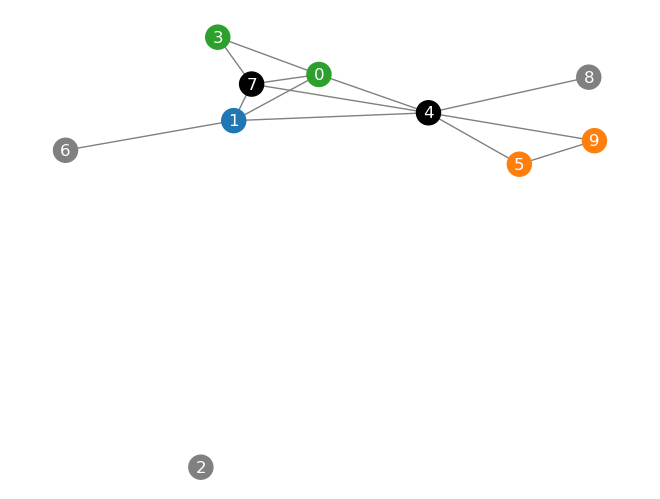

[[0 0 1 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [1 1 1 0]
 [0 1 0 0]
 [0 0 0 0]
 [1 0 1 1]
 [0 0 0 0]
 [0 1 0 0]]


In [32]:
N = 10
Q = 4  # Number of clusters

# Parameters
lambd = 4
epsilon = 1
alpha = [0.25, 0.25, 0.25, 0.25]  # Probabilities for each class
W = np.full((Q, Q), -epsilon)  # Interaction matrix
np.fill_diagonal(W, lambd)  # Diagonal with lambda

U = np.full(shape=Q, fill_value=epsilon)  # Sender effects
V = np.full(shape=Q, fill_value=epsilon)   # Receiver effects
W_star = -5.5  # Bias term

osbm = OSBM(N, Q, alpha, W, U, V, W_star)
osbm.sample_graph()
osbm.plot()
print(osbm.Z)

### Test with variational inference

In [95]:
osbm.variational_EM(Q=3, max_iter=100, tol=1e-6)

Initializing...
Iteration 1...
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
[[0.46501387 0.09529147 0.49375174]
 [0.5202925  0.11241871 0.34131219]
 [0.52301699 0.10577097 0.37038909]
 [0.4508592  0.10375998 0.43347866]
 [0.5791382  0.09197089 0.46946945]
 [0.59208129 0.09266317 0.456961  ]
 [0.4754592  0.11452708 0.33315391]
 [0.55130728 0.10362259 0.37569354]
 [0.56766913 0.09107546 0.47186776]
 [0.51554676 0.10007284 0.41981805]] [[0.46501387 0.09529147 0.49375175]
 [0.5202925  0.11241871 0.3413122 ]
 [0.52301699 0.10577097 0.3703891 ]
 [0.4508592  0.10375998 0.43347867]
 [0.5791382  0.09197089 0.46946946]
 [0.59208129 0.09266317 0.45696101]
 [0.4754592  0.11452708 0.33315392]
 [0.55130728 0.10362259 0.37569355]
 [0.56766913 0.09107546 0.47186777]
 [0.51554676 0.10007284 0.41981806]]
Converged in 1 iterations.


{'alpha': array([0.49848933, 0.10350794, 0.39800273]),
 'W': array([[ 0.11707922, -0.01152579, -0.02232516],
        [-0.01129015, -0.00030206, -0.02319424],
        [ 0.00110754, -0.04651674,  0.11620124]])}

In [38]:
# General parameters of network
N = 100 # Number of nodes
Q = 4  # Number of clusters

# Parameters
lambd = 4
epsilon = 1
alpha = [0.25, 0.25, 0.25, 0.25]  # Probabilities for each class
W = np.full((Q, Q), -epsilon)  # Interaction matrix
np.fill_diagonal(W, lambd)  # Diagonal with lambda

U = np.full(shape=Q, fill_value=epsilon)  # Sender effects
V = np.full(shape=Q, fill_value=epsilon)   # Receiver effects
W_star = -5.5  # Bias term

osbm = OSBM(N, Q, alpha, W, U, V, W_star)
osbm.sample_graph()

In [39]:
results = osbm.variational_EM(Q = 4)
results['alpha'], results['W']

Initializing...
Iteration 1...
[[  0.51081434   0.19933848   0.51480696   0.51471413]
 [ -9.45894441 -15.5190603   -9.27981143  -9.28196907]
 [ -0.02539575  -0.14756637  -0.02143448  -0.02249015]
 [ -0.0410295   -0.16558461  -0.03805684  -0.03706023]]


KeyboardInterrupt: 

In [36]:
def plot_adjacency_matrix(adjacency_matrix):
    """Plot adjacencu matrix with networkx with different colors for class""" 
    G = nx.from_numpy_matrix(adjacency_matrix)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=Z, with_labels=True)  
    plt.show()


plot_adjacency_matrix(X)

NameError: name 'X' is not defined